In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras.backend as K

gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
session = tf.Session(config=config) 
K.set_session(session)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU Not Found!')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.io import loadmat

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.utils import vis_utils

# configure matplotlib
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(42)

Data: http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat

In [3]:
H, W = 28, 20
N_PIX = H*W

ff = loadmat('data/frey_rawface.mat', squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, H, W))

In [4]:
X_train = ff[:1800]
X_val   = ff[1800:1900]

X_train = X_train.astype('float32') / 255.
X_val   = X_val.astype('float32') / 255.

X_train = X_train.reshape((len(X_train), N_PIX))
X_val   = X_val.reshape((len(X_val), N_PIX))

In [5]:
X_train.shape, X_val.shape

((1800, 560), (100, 560))

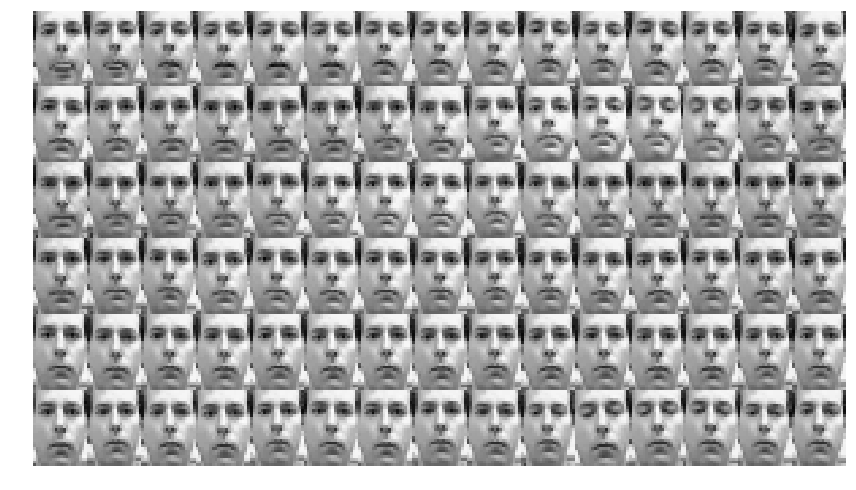

In [6]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None, img_size=(28,20)):
    img_rows, img_cols = img_size
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()

show_examples(ff, n=90, n_cols=15)

In [8]:
intermediate_dim = 256
latent_dim = 2
batch_size = 128
epochs = 100
noise_std = .01

In [9]:
# ENCODER
x = Input(shape=(N_PIX,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    bs = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bs, latent_dim), mean=0., stddev=noise_std)
    epsilon *= K.exp(.5 * z_log_var)
    epsilon += z_mean
    return epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])    

In [11]:
decoder_h1 = Dense(intermediate_dim, activation="relu")
decoder_h2 = Dense(N_PIX, activation="sigmoid")
z_decoded = decoder_h1(z)
x_decoded = decoder_h2(z_decoded)

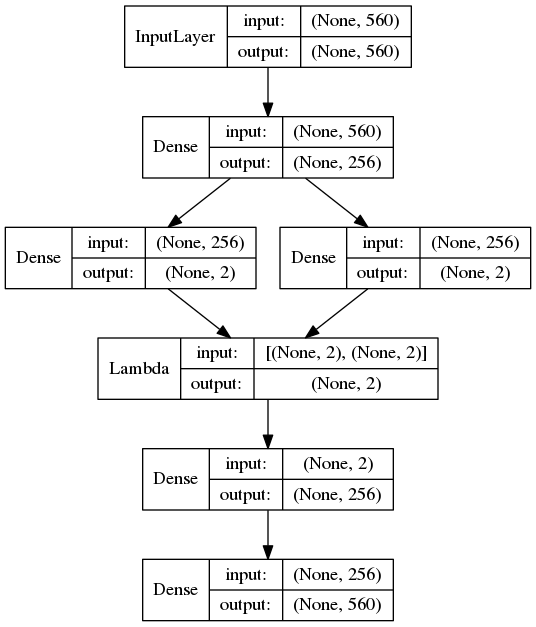

In [12]:
vae = Model(inputs=x, outputs=x_decoded)
vis_utils.plot_model(vae, "ff.png", show_layer_names=False, show_shapes=True)
Image.open('ff.png')

In [13]:
def vae_objective(x, x_decoded):
    loss = binary_crossentropy(x, x_decoded)
    kl_regu = -.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_regu

In [15]:
vae.compile(optimizer="adam", loss=vae_objective)

In [16]:
hist_cb = vae.fit(X_train, X_train, shuffle=True, 
                  epochs=epochs, batch_size=batch_size, 
                  verbose=0, validation_data=(X_val, X_val)
                 )

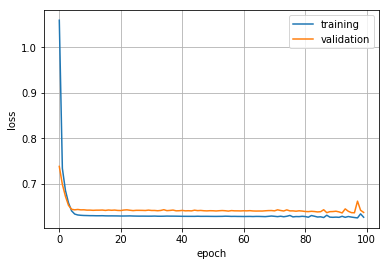

In [17]:
plt.plot(hist_cb.history["loss"], label="training")
plt.plot(hist_cb.history["val_loss"], label="validation")
plt.grid("on")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best");

In [19]:
encoder = Model(inputs=x, outputs=z_mean)

In [20]:
decoder_input = Input(shape=(latent_dim,))
h_decoded = decoder_h1(decoder_input)
x_decoded = decoder_h2(h_decoded)
generator = Model(inputs=decoder_input, outputs=x_decoded)

In [21]:
from ipywidgets import FloatSlider, interact

d = {'c'+str(i): FloatSlider(min=-15, max=15, step=3, value=0) for i in range(latent_dim)}

@interact(**d)
def do_thumb(**args):
    z_sample = np.array([list(args.values())]) * noise_std
    x_decoded = generator.predict(z_sample)
    face = x_decoded[0].reshape((H,W))
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(111)
    ax.imshow(face)
    plt.axis("off")

interactive(children=(FloatSlider(value=0.0, description='c0', max=15.0, min=-15.0, step=3.0), FloatSlider(val…